In [1]:
from dask.diagnostics import ProgressBar 
from dask.distributed import Client
from google.cloud import bigquery
from google.cloud import storage
from google.cloud.bigquery.client import Client
from icecream import ic
from icecream import ic 
from itertools import combinations
from joblib import dump
from joblib import load
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
import argparse
import dask
import dask.dataframe as dd
import logging
import math
import math, random
import matplotlib.pyplot as plt
import memory_profiler
import multiprocessing as mp
import numpy as np
import os
import os, shutil
import pandas as pd
import random
import time
import warnings
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential 
from keras.layers import Dense, Activation, LSTM, GRU, SimpleRNN
from keras.preprocessing.sequence import TimeseriesGenerator
import random
import pickle
from sklearn.preprocessing import StandardScaler
import sys
from keras.utils.vis_utils import plot_model
from IPython.display import Image
import time
import subprocess
import tensorflow as tf

from sklearn.metrics import mean_squared_error
#%load_ext memory_profiler
#%matplotlib inline

warnings.filterwarnings('ignore')
sys.path.insert(1, './transformers')

print("Pandas version: ", pd.__version__)
print("Dask   version: ", dask.__version__)


Pandas version:  1.3.2
Dask   version:  2021.09.0


In [2]:
from utils import flip_from_probability, EMA, rollingWindow
from utils import saveObj, loadObj, getBetwDates, getDate
from data_manager import DataManager
from module import Module

In [3]:
daskClient = Client()#n_workers=8
module = Module.getInstance(daskClient)
envVarsService = module.EnvVarsService()
storageService = module.StorageService()
datawarehouseService = module.DatawarehouseService()

----------------------
/home/jupyter/transformers
/home/jupyter/transformers/credentials/cred.json


In [4]:
ricList = subprocess.check_output(['ls', 'process-data']).decode('utf-8').split('\n')
ricList = [r.replace('ric_','') for r in ricList if len(r)][:10]

In [5]:
ricList

['.NDX',
 'AAPL.OQ',
 'ADBE.OQ',
 'ADI.OQ',
 'ADP.OQ',
 'ADSK.OQ',
 'AEP.OQ',
 'ALGN.OQ',
 'ALXN.OQ',
 'AMAT.OQ']

In [6]:

#list de experimentos
expList = ['experimento_'+str(i) for i in range(4)]

In [7]:
ric = "AAPL.OQ"
modelType = 'LSTM'
exp = expList[0]

In [8]:
window = 60
forecast = 1
nb_epoch = 10#10000
batch_size = 3

In [9]:
#Carpeta de ric
folderRic = 'ric_'+ric


#Ruta del repo
path_main = os.getcwd()

#Ruta del experimento
expPath = path_main+'/process-data/'+folderRic+'/'+exp

#Configuracion del experimento
config = loadObj(expPath+'/config.pickle')

#Datos
filePath = expPath+'/dataset.csv'
df = pd.read_csv(filePath)

#Administrador de datos
dataManager = DataManager(df,
                 ric,
                 config,
                 window,
                 forecast,
                 algorithm = 'Transformer')

train = np.reshape(dataManager.df_train['log_diff_scaled'].values.astype('float32'),(-1,1))
test  = np.reshape(dataManager.df_test['log_diff_scaled'].values.astype('float32'),(-1,1))

#Generadores
train_generator = TimeseriesGenerator(
    np.reshape(dataManager.df_train['log_diff_scaled'].values.astype('float32'),(-1,1)), 
    np.reshape(dataManager.df_train['log_diff_scaled'].values.astype('float32'),(-1,1)), 
    length=window, 
    batch_size=512)     
test_generator = TimeseriesGenerator(
    np.reshape(dataManager.df_test['log_diff_scaled'].values.astype('float32'),(-1,1)), 
    np.reshape(dataManager.df_test['log_diff_scaled'].values.astype('float32'),(-1,1)), 
    length=window, 
    batch_size=512)

In [10]:
history = loadObj(expPath+'/LSTM_model.history')

In [11]:
print(history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


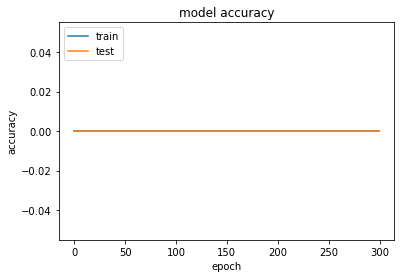

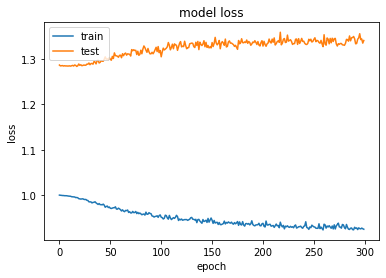

In [12]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

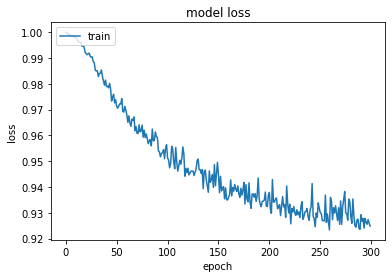

In [13]:
# summarize history for loss
plt.plot(history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

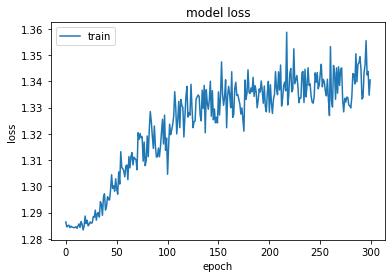

In [14]:
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [43]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

In [44]:
scaler = loadObj(expPath+'/scaler.pickle')

In [48]:
errors = {}
models = {}
for m in ['LSTM','GRU']:
    models[m] = tf.keras.models.load_model(expPath+'/'+m+'_model.h5')
    trainPredict = models[m].predict_generator(train_generator)
    testPredict = models[m].predict_generator(test_generator)
    trainPredictUnscaled = scaler.inverse_transform(trainPredict)
    testPredictUnscaled = scaler.inverse_transform(testPredict)
    
    df[m] = 0
    df.loc[window:len(trainPredict)+window-1, m] = trainPredictUnscaled
    df.loc[len(trainPredict)+(window*2):len(df), m] = testPredictUnscaled
    df[m] = np.exp(df[m] + np.log(df['y'].shift(1)))
    
    
    print(m)
    # calculate root mean squared error
    trainScore = \
        math.sqrt(mean_squared_error(
            df.loc[window:len(trainPredict)+window-1, m], 
            df.loc[window:len(trainPredict)+window-1, 'y']))
    print('Train Score: %.5f RMSE' % (trainScore))
    testScore = \
        math.sqrt(mean_squared_error(
            df.loc[len(trainPredict)+(window*2):len(df), m], 
            df.loc[len(trainPredict)+(window*2):len(df), 'y']))
    print('Test Score: %.5f RMSE' % (testScore))
    
    errors[m] = {
        'Train RMSE': trainScore,
        'Test RMSE': testScore,
    }
    

LSTM
Train Score: 0.03014 RMSE
Test Score: 0.03166 RMSE
GRU
Train Score: 0.03030 RMSE
Test Score: 0.03144 RMSE


In [42]:
#trainY = scaler.inverse_transform(get_y_from_generator(train_generator))
#testY = scaler.inverse_transform(get_y_from_generator(test_generator))

In [32]:
df.head(70).tail(20)

timestamp       y        date  log_diff  log_diff_scaled  \
50  2020-01-02 04:01:36+00:00  295.25  2020-01-02  0.000000        -0.001226   
51  2020-01-02 04:01:37+00:00  295.25  2020-01-02  0.000000        -0.001226   
52  2020-01-02 04:01:38+00:00  295.25  2020-01-02  0.000000        -0.001226   
53  2020-01-02 04:01:39+00:00  295.25  2020-01-02  0.000000        -0.001226   
54  2020-01-02 04:01:40+00:00  295.25  2020-01-02  0.000000        -0.001226   
55  2020-01-02 04:01:41+00:00  295.25  2020-01-02  0.000000        -0.001226   
56  2020-01-02 04:01:42+00:00  295.25  2020-01-02  0.000000        -0.001226   
57  2020-01-02 04:01:43+00:00  295.25  2020-01-02  0.000000        -0.001226   
58  2020-01-02 04:01:44+00:00  295.25  2020-01-02  0.000000        -0.001226   
59  2020-01-02 04:01:45+00:00  295.25  2020-01-02  0.000000        -0.001226   
60  2020-01-02 04:01:46+00:00  295.25  2020-01-02  0.000000        -0.001226   
61  2020-01-02 04:01:47+00:00  295.25  2020-01-02  0.000000        -0.001226   
62  2020-01-02 04:01:48+00:00  295.39  2020-01-02  0.000474         5.753375   
63  2020-01-02 04:01:49+00:00  295.39  2020-01-02  0.000000        -0.001226   
64  2020-01-02 04:01:50+00:00  295.39  2020-01-02  0.000000        -0.001226   
65  2020-01-02 04:01:51+00:00  295.39  2020-01-02  0.000000        -0.001226   
66  2020-01-02 04:01:52+00:00  295.39  2020-01-02  0.000000        -0.001226   
67  2020-01-02 04:01:53+00:00  295.39  2020-01-02  0.000000        -0.001226   
68  2020-01-02 04:01:54+00:00  295.39  2020-01-02  0.000000        -0.001226   
69  2020-01-02 04:01:55+00:00  295.39  2020-01-02  0.000000        -0.001226   

    LSTM_log_diff_scaled  GRU_log_diff_scaled  TRANSFORMER_log_diff_scaled  \
50                     0                    0                            0   
51                     0                    0                            0   
52                     0                    0                            0   
53                     0                    0                            0   
54                     0                    0                            0   
55                     0                    0                            0   
56                     0                    0                            0   
57                     0                    0                            0   
58                     0                    0                            0   
59                     0                    0                            0   
60                     0                    0                            0   
61                     0                    0                            0   
62                     0                    0                            0   
63                     0                    0                            0   
64                     0                    0                            0   
65                     0                    0                            0   
66                     0                    0                            0   
67                     0                    0                            0   
68                     0                    0                            0   
69                     0                    0                            0   

    Transformer_log_diff_scaled        LSTM  
50                            0  295.250000  
51                            0  295.250000  
52                            0  295.250000  
53                            0  295.250000  
54                            0  295.250000  
55                            0  295.250000  
56                            0  295.250000  
57                            0  295.250000  
58                            0  295.250000  
59                            0  295.250000  
60                            0  295.250131  
61                            0  295.250126  
62                            0  295.250126  
63                            0  295.387141  
64        

<AxesSubplot:>

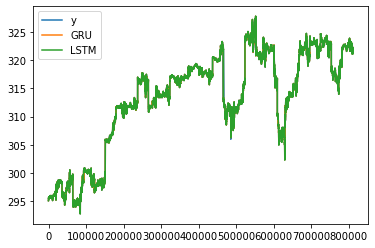

In [49]:
df[['y', 'GRU', 'LSTM']].plot()